# Geometry Manipulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Read and display magnetic geometry
- In this example, we read an already extracted geometry from a pickle file and plot the outer divertor leg.
- You will need to prepare your own from an equilibrium or SOLPS balance file using SOLPSreader.py.



Connection length: 38.70m
Total flux expansion: 1.88


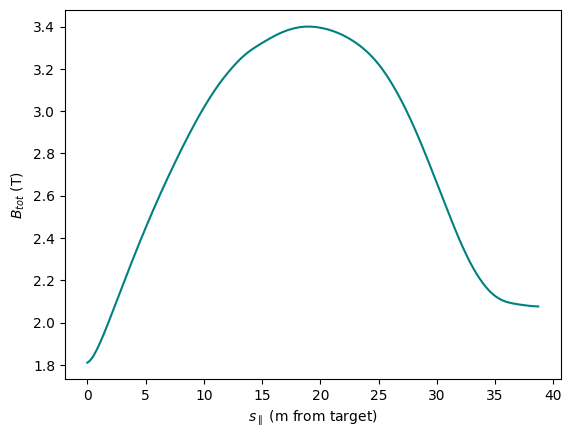

In [2]:
from fusiondls import MagneticGeometry

base = MagneticGeometry.from_pickle("eqb_store.pkl", "V10", "ol")

base.plot()
print(f"Connection length: {base.connection_length:.2f}m")
print(f"Total flux expansion: {base.total_flux_expansion:.2f}")

## Simple profile modification: scaling properties
- `MagneticGeometry` has methods to easily scale flux expansion and connection length by either a constant factor, or to a specific value.
- The resulting profile can be used as normal apart from that its R and Z coordinates are no longer valid.

Text(0.5, 1.0, 'Scaling total flux expansion and connection length by x1.5')

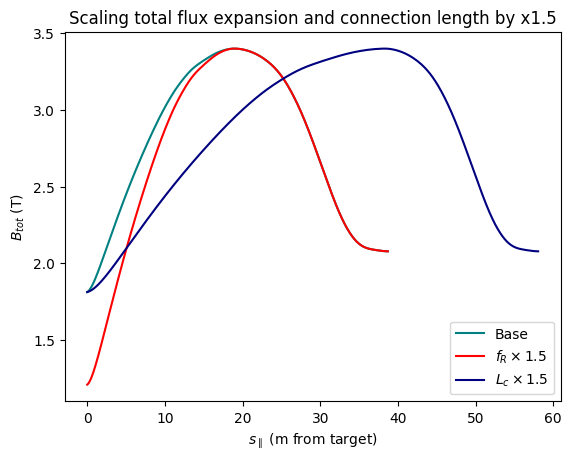

In [3]:
# Scale total flux expansion by x1.5
scale_flux_exp = base.scale_flux_expansion(scale_factor=1.5, name="scale_flux_exp")

# Scale total parallel connection length by x1.5
scale_conn_length = base.scale_connection_length(
    scale_factor=1.5, name="scale_conn_length"
)

fig, ax = plt.subplots()
base.plot(ax=ax, mode="Btot", color="teal", label="Base")
scale_flux_exp.plot(
    ax=ax, mode="Btot", color="red", label=r"$f_R \times 1.5$", legend=False
)
scale_conn_length.plot(
    ax=ax, mode="Btot", color="navy", label=r"$L_c \times 1.5$", legend=False
)

ax.legend()
ax.set_title("Scaling total flux expansion and connection length by x1.5")

### Tests

Checks that DLS-Extended is scaling the profiles to the right total flux expansions and connection lengths as well as that the magnetic pitch hasn't changed.

In [4]:
def diagnose_geometries(*geometries: MagneticGeometry):
    """
    Collect total flux expansion, connection length and average B pitch for a list of geometries
    """
    flux_expansions = []
    conn_lengths = []
    Bpitch_averages = []

    for geometry in geometries:
        flux_expansions.append(geometry.total_flux_expansion)
        conn_lengths.append(geometry.connection_length)
        Bpitch_averages.append(geometry.Bpitch_average)

    return {
        "flux_expansions": flux_expansions,
        "conn_lengths": conn_lengths,
        "Bpitch_averages": Bpitch_averages,
    }


def test_geometries(reference, data, test_name):
    """
    Compare geometry properties against a reference
    """
    np.testing.assert_allclose(
        data["flux_expansions"],
        reference["flux_expansions"],
        err_msg=f"FAIL - {test_name}, flux expansion",
    )
    np.testing.assert_allclose(
        data["conn_lengths"],
        reference["conn_lengths"],
        err_msg=f"FAIL - {test_name}, connection length",
    )
    np.testing.assert_allclose(
        data["Bpitch_averages"],
        reference["Bpitch_averages"],
        err_msg=f"FAIL - {test_name}, average B pitch",
    )


data = diagnose_geometries(base, scale_flux_exp, scale_conn_length)

reference = {
    "flux_expansions": [1.8765058115332327, 2.8147587172998474, 1.8765058115332327],
    "conn_lengths": [38.70054472714888, 38.70054472714888, 58.050817],
    "Bpitch_averages": [0.2624780194041092, 0.3383650617499022, 0.2624780194041092],
}

test_geometries(reference, data, "geometry scaling")

## Running DLS-Extended to find detachment threshold only
To find the impact of scaling connection length and flux expansion on detachment access, you can run DLS-Extended for with the front location at the target only (Spar = 0). This corresponds to detachment threshold conditions.

First let's set up the inputs. We are using argon and solving for density:

In [5]:
from fusiondls import SimulationInputs
from fusiondls.analytic_cooling_curves import LfuncKallenbach

settings = SimulationInputs(
    control_variable="density",  # Solve for density
    SparRange=np.zeros(1),  # Solve only at target to get threshold
    qpllu0=1e9,  # Constant heat flux density at the x point
    nu0=1e20,  # Initial upstream density
    cz0=0.02,  # Constant impurity fraction
    cooling_curve=LfuncKallenbach("Ar"),  # impurity cooling function
)

Because we only have one front location, we don't need a FrontLocationScan post-processing class and can just use FrontLocation and access its stats attribute which contains the control variable output, in this case upstream density.

In [6]:
from fusiondls import run_dls
from fusiondls.postprocessing import FrontLocation

print("Density required for detachment threshold:")
thresholds = []
for geometry in (base, scale_flux_exp, scale_conn_length):
    results = run_dls(settings, geometry)
    threshold = FrontLocation(results).stats["cvar"]  # cvar = control variable
    print(f"   {geometry.name}: {threshold:.2e} [m^-3]")
    thresholds.append(threshold)

Density required for detachment threshold:
   base: 6.41e+19 [m^-3]
   scale_flux_exp: 4.74e+19 [m^-3]
   scale_conn_length: 5.25e+19 [m^-3]


### Test

In [7]:
np.testing.assert_allclose(
    thresholds,
    [6.407163951374368e19, 4.737002481352016e19, 5.245747e19],
    err_msg="FAIL - Single front location runs with scaled fR and Lc",
)

## Creating and offsetting control points
- Profiles can be modified by changing the R,Z coordinates of the divertor leg.
- This can be achieved by either offsetting them vertically/horizontally, or specifying coordinates in the "offsets" object, which is a list of dictionaries. Each one defines a control point, where "pos" is its location along the connection length (0 being at the target, and 1 at the X-point) and either offsets or positions are specified.
- At least 4 control points are required for the interpolation to work! If you are having issues getting the shape you want, adding more control points helps.
- The function `offset_control_points` outputs an object containing both a new profile and intermediate data used in the calculation. This object can be used to plot the modified profile. The profile itself is accessible in the `profile` attribute.

Text(0.5, 1.0, 'Modifying leg profile in two ways')

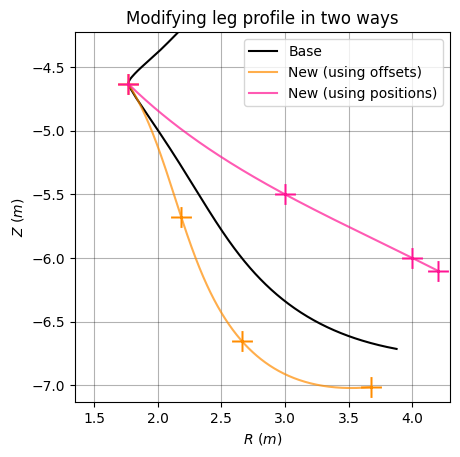

In [8]:
# Arbitrary change in field line profile using X and Y (R and Z) offsets
offsets1 = [
    {"pos": 1},
    {"pos": 0.75, "offsety": -0.4},
    {"pos": 0.25, "offsetx": -0.5, "offsety": -0.20},
    {"pos": 0, "offsetx": -0.2, "offsety": -0.3},
]

arbitrary_offset = base.offset_control_points(offsets1, name="New (using offsets)")

# Arbitrary change in field line profile using X and Y (R and Z) positions
offsets2 = [
    {"pos": 1},
    {"pos": 0.75, "posx": 3.0, "posy": -5.5},
    {"pos": 0.25, "posx": 4.0, "posy": -6.0},
    {"pos": 0, "posx": 4.2, "posy": -6.1},
]

arbitrary_pos = base.offset_control_points(offsets2, name="New (using positions)")

fig, ax = plt.subplots()
base.plot(mode="RZ", ax=ax, full_RZ=True, color="black", label="Base")
arbitrary_offset.plot_control_points(ax=ax, color="darkorange")
arbitrary_pos.plot_control_points(ax=ax, color="deeppink")

ax.legend()
ax.set_title("Modifying leg profile in two ways")

### Tests

In [9]:
data = diagnose_geometries(base, arbitrary_offset.geometry, arbitrary_pos.geometry)
reference = {
    "flux_expansions": [1.8765058115332327, 1.804315734121157, 1.987284052627064],
    "conn_lengths": [38.70054472714888, 40.392918691141276, 36.59560470985993],
    "Bpitch_averages": [0.2624780194041092, 0.2440918734204125, 0.2863634649903951],
}

test_geometries(reference, data, "modifying profiles with offsets")

## Interpolating profiles
- Intermediate profiles can be generated by specifying a factor when offsetting control points.

Text(0.5, 1.0, 'Creating intermediate profiles')

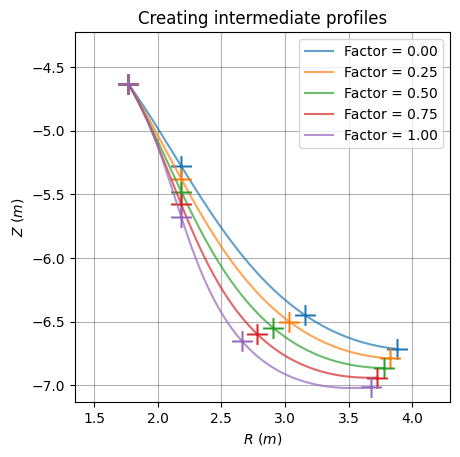

In [10]:
# Take one of the profiles from the previous example
offsets1 = [
    {"pos": 1},
    {"pos": 0.75, "offsety": -0.4},
    {"pos": 0.25, "offsetx": -0.5, "offsety": -0.20},
    {"pos": 0, "offsetx": -0.2, "offsety": -0.3},
]

# Generate several intermediate profiles between the base and modified profiles
# Offsets are applied with a factor between 0 and 1
offset_results = [
    base.offset_control_points(offsets1, factor=factor, name=f"Factor = {factor:.2f}")
    for factor in (0, 0.25, 0.5, 0.75, 1.0)
]

fig, ax = plt.subplots()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for result, color in zip(offset_results, colors):
    result.plot_control_points(ax=ax, color=color)

ax.legend()
ax.set_title("Creating intermediate profiles")

### Tests

In [11]:
data = diagnose_geometries(offset_results[1].geometry, offset_results[-1].geometry)
reference = {
    "flux_expansions": [1.8587371218287396, 1.804315734121157],
    "conn_lengths": [38.87920425263975, 40.392918691141276],
    "Bpitch_averages": [0.25809108643509543, 0.2440918734204125],
}

test_geometries(reference, data, "creating intermediate profiles through offsets")

## Changing magnetic pitch angle assumption
- The relationship between parallel and poloidal connection length can be changed by altering the magnetic pitch angle.
- A shallower angle reduces poloidal front movement for the same parallel distance. 
- Reduction in pitch angle is achieved by increasing Bpol, or "poloidal flux expansion".
- By default, profile manipulation preserves magnetic pitch. This can be disabled so that the Bpol profile is preserved instead. 

Note that in the example shown, preserving pitch does not produce an exact match to the base profile due to the change in connection length.

Text(0.5, 1.0, 'New profile with and without preserving magnetic pitch')

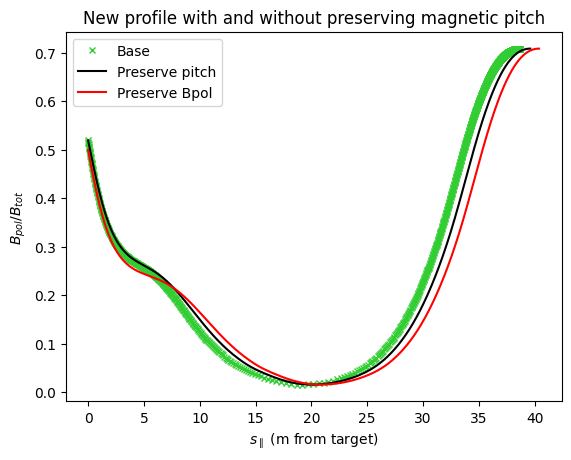

In [12]:
offsets1 = [
    {"pos": 1},
    {"pos": 0.75, "offsety": -0.4},
    {"pos": 0.25, "offsetx": -0.5, "offsety": -0.20},
    {"pos": 0, "offsetx": -0.2, "offsety": -0.3},
]

preserve_pitch = base.offset_control_points(
    offsets1, constant_pitch=True, name="Preserve pitch angle"
)
preserve_Bpol = base.offset_control_points(offsets1, name="Preserve Bpol (default)")

fig, ax = plt.subplots()
base.plot(
    mode="magnetic_pitch",
    ax=ax,
    color="limegreen",
    label="Base",
    lw=0,
    ms=5,
    marker="x",
)
preserve_pitch.geometry.plot(
    mode="magnetic_pitch", ax=ax, color="black", label="Preserve pitch"
)
preserve_Bpol.geometry.plot(
    mode="magnetic_pitch", ax=ax, color="red", label="Preserve Bpol"
)
ax.legend()
ax.set_title("New profile with and without preserving magnetic pitch")

### Tests

In [13]:
data = diagnose_geometries(preserve_pitch.geometry, preserve_Bpol.geometry)
reference = {
    "flux_expansions": [1.7796735440727995, 1.804315734121157],
    "conn_lengths": [39.60469896353156, 40.392918691141276],
    "Bpitch_averages": [0.2624780194041092, 0.2440918734204125],
}

test_geometries(
    reference,
    data,
    "preservation of magnetic pitch or poloidal field during profile modification",
)

## Adding poloidal flux expansion
- Poloidal flux expansion can be added using a Gaussian function representing an increase or decrease of the poloidal B field.
- This is done by passing a dictionary to recalculate_topology().

Text(0.5, 1.0, 'Introducing poloidal flux expansion at $s_{\\theta} = 1m$')

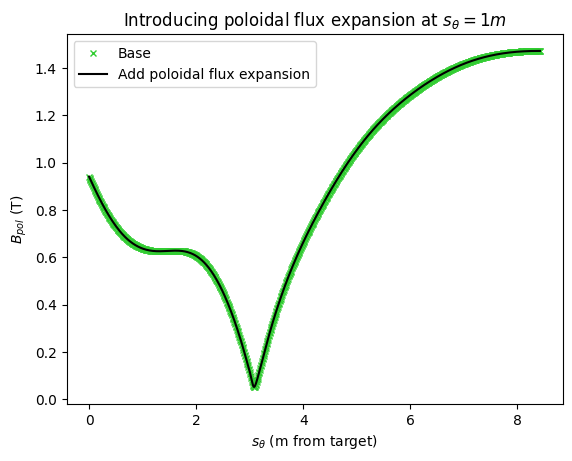

In [14]:
# Let's not adjust the profile at all
offsets1 = [
    {"pos": 1},
    {"pos": 0.75},
    {"pos": 0.25},
    {"pos": 0},
]

poloidal_flux_expansion = base.offset_control_points(
    offsets1,
    Bpol_shift={"width": 0.2, "pos": 1, "height": 0.2},  # Bpol gaussian
).geometry

fig, ax = plt.subplots()
base.plot(
    mode="Bpol",
    ax=ax,
    color="limegreen",
    label="Base",
    parallel=False,
    lw=0,
    ms=5,
    marker="x",
)

poloidal_flux_expansion.plot(
    mode="Bpol",
    ax=ax,
    color="black",
    parallel=False,
    label="Add poloidal flux expansion",
)

ax.legend()
ax.set_title(r"Introducing poloidal flux expansion at $s_{\theta} = 1m$")

### Tests

In [15]:
data = diagnose_geometries(base, poloidal_flux_expansion)
reference = {
    "flux_expansions": [1.8765058115332327, 1.8765058115332327],
    "conn_lengths": [38.70054472714888, 38.43033663908888],
    "Bpitch_averages": [0.2624780194041092, 0.2627647580528424],
}

test_geometries(
    reference,
    data,
    "Poloidal flux expansion",
)

## Generating scans in strike point position
- A profile can be automatically interpolated to a desired strike point position.
- This is done by spline interpolation through selected control points, in this case [1, 0.6, 0.59, 0].
- The selection of control points may need to be tuned to get a good result, in particular putting more points near the target can prevent the profile from kinking upwards.

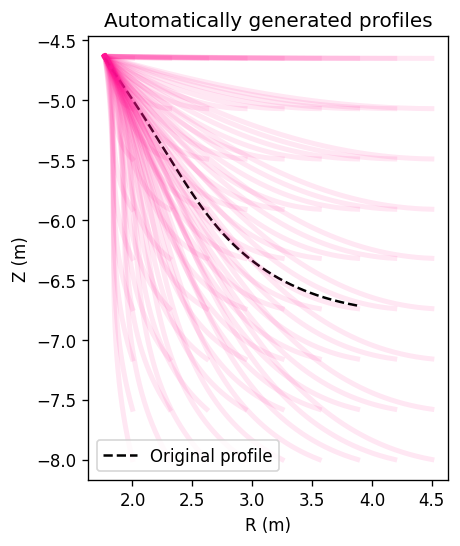

In [16]:
## Make a 9x9 grid of strike points.
res = 9
list_x = np.linspace(2, 4.5, res).round(2)
list_y = np.linspace(-4.65, -8, res).round(2)

fig, ax = plt.subplots(dpi=120)

base.plot(ax=ax, mode="RZ", color="k", ls="--", label="Original profile")

positions = np.array([1, 0.6, 0.2, 0])
new_profiles = {}
for x in list_x:
    new_profiles[x] = {}
    for y in list_y:
        offsets = base.get_offsets_strike_point(positions, x, y)
        new_profile = base.offset_control_points(offsets).geometry
        new_profile.plot(ax=ax, mode="RZ", color="deeppink", ls="-", lw=3, alpha=0.1)

        new_profiles[x][y] = new_profile

ax.set_aspect("equal")
ax.set_title("Automatically generated profiles")
ax.legend()

### Tests

In [17]:
data = diagnose_geometries(
    new_profiles[list_x[1]][list_y[2]],
    new_profiles[list_x[3]][list_y[4]],
    new_profiles[list_x[8]][list_y[1]],
)

reference = {
    "flux_expansions": [1.2305658660398024, 1.5127205835839528, 2.083108035364263],
    "conn_lengths": [27.274323680656845, 33.742208479713135, 35.51099946107371],
    "Bpitch_averages": [0.19333070153260676, 0.22032866595354764, 0.30189223747121485],
}

test_geometries(
    reference,
    data,
    "Strike point position scan",
)